In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

# An Introduction to the Twin Networks package
This package makes it easy to build Structural Causal Models and run counterfactual queries on them. Specifically, it is a library that allows you to:

1. Create SCMs (from random or a prespecified model), parameterize them, and sample from them.
2. Represent an SCM as a Twin Network.
3. Run exact inference for counterfactual queries on the standard or Twin network.
4. Run approximate inference for counterfactual queries on the standard or Twin network.

Exact inference uses the `pgmpy` package (using variable elimination).
Approximate inference uses `Pyro`.

We also encourage you to look at [MultiVerse](https://github.com/babylonhealth/multiverse), a prototype Probabilistic Programming Engine meant for counterfactual inference.

## 1. Generating and Sampling from an SCM

In [3]:
## add relative path
import sys
sys.path.append('../src/')

## this is the main package you'll need.
from scm import CausalModel

### 1.1 Generating an SCM

Generating an SCM from random is straightforward. You specify the size (number of endogenous nodes), type of variables (currently binary or continuous), generation method (density, backward, random, or from a DAG), and an SCM with exogenous nodes and functional parameterizations will be generated for you:

In [163]:
scm = CausalModel(continuous=True)       # Exogeneous variables are N(0, 1) and all functions are random 3-layer neural nets
scm.create(method='density',             # The graph is generated via forward density. In this case, prob of 0.5 implies 50% density.
           n_nodes=4,
           prob=0.75)                     # this parameter name is specific to the 'density' method (see function docstring)
print(scm.G.nodes)                       # The graph is stored in the `G` attribute and is a networkx.classes.digraph.DiGraph instance.

['N0', 'N1', 'N2', 'N3', 'UN0', 'UN1', 'UN2', 'UN3']


Here, 4 endogenous nodes were created `['N0', 'N1', 'N2', 'N3']`, and each of them were given an independent noise term `UNi`. You can plot the graph inline easily:

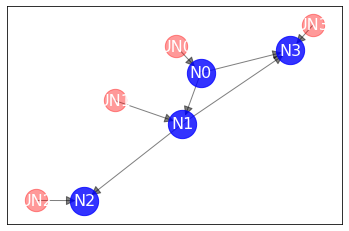

In [164]:
scm.draw()

If you have a `networkx.classes.digraph.DiGraph` graph of _only endogenous variables_ (such as a Bayesian Network) you'd like to use, you can use the `scm.create_from_DAG(...)` method instead. This will convert it into a parameterized SCM with exogenous variables.

### 1.2 Sampling from the SCM
Samping is really easy with the `.sample()` method. You can modify what node values it return and in what format:

In [165]:
s = scm.sample(n_samples=1000, return_pandas=True)
s.head()

,UN0,UN1,UN2,UN3,N0,N1,N3,N2
0,0.613455,-0.180783,0.233198,0.195438,0.613455,-1.341515,-8.704080,-0.431450
1,0.164977,-0.215764,0.273962,-0.249279,0.164977,-1.332023,-7.232595,-0.384573
2,0.146662,-0.249907,0.373133,0.523522,0.146662,-1.375192,-6.383549,-0.313053
3,0.614165,-0.172109,0.076678,0.182732,0.614165,-1.333363,-8.708834,-0.582721
4,0.571748,-0.149671,0.376813,0.943123,0.571748,-1.281607,-7.772766,-0.248849


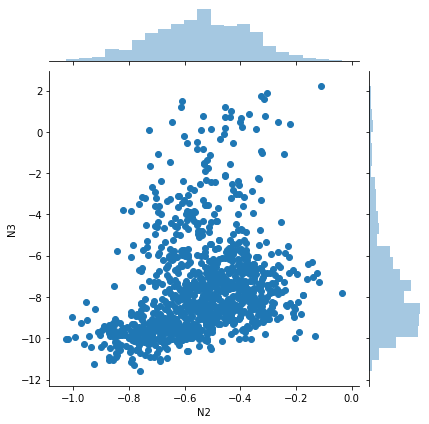

In [166]:
sns.jointplot(s['N2'], s['N3'])

### 1.3 Modifying functions

Note than in our random parameterization of the SCM, each endogenous node is given a random neural network that is a function of all its endogenous parent nodes. You can change each endogenous node's generating function assignments if you like.

A function is valid if it takes in an `[n x m]` Torch tensor (where `m` is the number of endogenous parents) and outputs an `[n x 1]` torch tensor of the same type.

In [167]:
scm.G.nodes['N1']['fn'] = lambda X: torch.sum(X, dim=1).reshape(-1, 1)

In [168]:
scm.sample(n_samples=3, return_pandas=True)

,UN0,UN1,UN2,UN3,N0,N1,N3,N2
0,0.564994,-0.273928,0.074246,-0.019968,0.564994,0.291066,-3.733667,3.340453
1,-0.128040,-0.182515,0.090146,1.092302,-0.128040,-0.310555,-0.148967,1.199769
2,0.293881,-0.153457,-0.024896,-0.317926,0.293881,0.140424,-3.492264,2.972615


Note that you only specify a function taking in **endogenous** parents. This is because it handles exogenous noise separately. Currently, the only supported exogenous noise function is additive noise.

### 1.4 Creating a Twin Network
You can convert this SCM into a twin network really easily:

In [169]:
scm.create_twin_network()
print(scm.twin_G.nodes)

['N0', 'N1', 'N2', 'N3', 'UN0', 'UN1', 'UN2', 'UN3', 'N0tn', 'N1tn', 'N2tn', 'N3tn']


Twin nodes are labeled with "tn" in the name. Functions have been copied to this new network.

## 2. Running Exact Inference

In [170]:
from exact import ExactCounterfactual
from experiments import Experiment

First we need to generate an experiment to run. We use the `Experiment` class to generate different types of experiments, each of which consist of a counterfactual query composed of $\{G, Y^*, E, D\}$, where $G$ is the `CausalModel` on which the experiment happens, $Y^*$ is the _counterfactual node of interest_, $E$ is the evidence to observe for abduction, and $D$ is the _intervention_. Let's set up an experiment:

In [171]:
e = Experiment()
scm, node_of_interest, evidence, d_intervention = e.size_experiment(10)  # at this moment, this only generates binary networks.
print(type(scm))
print("Node of interest:\t{}".format(node_of_interest))
print("Evidence:\t\t{}".format(evidence))
print("Intervention:\t\t{}".format(d_intervention))

<class 'scm.CausalModel'>
Node of interest:	N2
Evidence:		{'N7': 1, 'N0': 0, 'N9': 1, 'N4': 0}
Intervention:		{'N0': 1}


We can then pass these experimental parameters to a `Counterfactual` instance to run exact inference. Using the `.construct(scm)` creates a `pgmpy` Bayesian network with CPTs that are based on samples, on which you can run Variable Elimination.

In [172]:
cf = ExactCounterfactual(merge=True)  # merge == True turns on node merging when you run twin network inference
cf.construct(scm, n_samples=30000)  # parameterize the CPTs from 30000 samples from the SCM.

We can run different types of queries. We could run standard counterfactual inference (SCI), performing abduction-intervention-prediction in turn. Or, we could perform twin network inference. Let's try both.

### 2.1 Standard Counterfactual Inference

Here I'll run *abduction-intervention-prediction* explicitly, then I'll show you the method that does all three at once. First, abduction, which runs VariableElimination to create $P(U | X)$, then replaces the CPDs for all endogeneous nodes (an approximation that I'll show how to fix in 2.1.2).

In [173]:
cf.abduction(evidence)

Eliminating: N1: 100%|██████████| 6/6 [00:00<00:00, 45.95it/s]


`.abduction(evidence)` creates a new attribute, `counterfactual_model`, that contains a new Bayesian Network with CPTs replaced with a new marginal CPT. This is an approximation that we use which approximates sampling from the joint posterior. We'll show how to do "perfect" exact inference in the next section. But first, we intervene:

In [174]:
cf.intervene(d_intervention, counterfactual=True)

and last, we predict:

In [175]:
cf.sample(10000, counterfactual=True)[node_of_interest].mean()

Generating for node: N6: 100%|██████████| 19/19 [00:02<00:00,  7.85it/s]


0.4415

where previously, the interventional estimate for N4 (given the evidence) was:

In [176]:
scm.reset_graph()
cf.construct(scm)

cf.intervene(d_intervention)
prediction = cf.query(node_of_interest, evidence)

Eliminating: N1: 100%|██████████| 14/14 [00:00<00:00, 607.48it/s]


In [177]:
prediction[0].values[1]  # get the probability that the value is 1

0.5548767840934556

That is, the counterfactual estimate is about 20% lower than the interventional estimate. The counterfactual information makes a big difference.

## 3. Running Approximate Inference

In most cases, you probably want to run approximate inference. This occurs for the most part when the graph is large enough to make exact inference intractable, or the variables are continuous rendering approximate inference necessary. For this purpose, we developed the `approximate.py` module, which wraps around a `CausalModel` object.

In [184]:
from approximate import *

First, create a causal model:

In [185]:
scm = CausalModel(continuous=True)
n_nodes = 10
scm.create("density", n_nodes, prob=0.5)

Then we can use the approximate wrapper:

In [186]:
app = ApproximateCounterfactual(prior_mean=0., prior_variance=4.)
app.construct(scm)

The `ApproximateCounterfactual` instance has converted the `CausalModel` into a `Pyro` model and corresponding guide. The model has two components:

1. Exogenous Nodes, which are `pyro.distributions.Normal` objects, i.e. they have a Normal prior.
2. Endogenous Nodes, which are `pyro.distributions.Delta` objects, i.e. Delta-distributed around the outcome of the node's generating function. Endogenous nodes are thus deterministically determined by their endogenous and exogenous parents.

You can sample from the model:

In [187]:
app.model()

{'UN9': tensor([-1.0188]),
 'UN8': tensor([1.2218]),
 'UN7': tensor([-2.5615]),
 'UN6': tensor([3.5748]),
 'UN5': tensor([-4.0608]),
 'UN4': tensor([5.3585]),
 'UN3': tensor([4.5340]),
 'UN2': tensor([9.5910]),
 'UN1': tensor([-0.6833]),
 'N1': tensor([-0.6833]),
 'UN0': tensor([-2.2523]),
 'N0': tensor([-2.2523]),
 'N2': tensor([13.2645]),
 'N3': tensor([9.9231]),
 'N4': tensor([4.6218]),
 'N6': tensor([2.5538]),
 'N7': tensor([-1.2771]),
 'N5': tensor([-0.7826]),
 'N8': tensor([5.2562]),
 'N9': tensor([-3.9462])}

We'll generate an experiment with continuous valuables first (this is just custom boilerplate):

In [188]:
def sample_counterfactual(scm, intv, noi, nodes_to_observe=['N0', 'N2']):
    # create approximate model
    app = ApproximateCounterfactual()
    app.construct(scm)
    sample = scm.sample(return_pandas=True).to_dict("list")
    sample = {k: torch.tensor(sample[k]) for k in sample}

    # sample evidence, latent state, and intervention
    evidence = {k: sample[k] for k in sample if k in nodes_to_observe}
    latent = {k: sample[k] for k in sample if k[0] == "U"}
    
    # create intervened (counterfactual) model
    app._intv_nodes = [k for k in intv]
    intervened_model = pyro.do(app.model, {**latent, **intv})  ## this is where it fails
    
    ## either change Model() so it takes in 
    
    # get true counterfactual value
    cf_value = intervened_model()[noi]
    
    return cf_value, sample[noi], evidence, latent

def generate_counterfactual(scm, intv_node, noi, nodes_to_observe=["N0", "N2"], max_iters=500):
    sample = scm.sample(1000, return_pandas=True)
    noi_sample = sample[noi]
    
    intv_sample = sample[intv_node]
    intv = np.random.choice([np.percentile(intv_sample, 80), np.percentile(intv_sample, 20)])
    intv = {intv_node: torch.tensor([intv])}
    
    iqr = np.abs(np.percentile(noi_sample, 75) - np.percentile(noi_sample, 25))
    cf_value, pre, evidence, latent = sample_counterfactual(scm, intv, noi, nodes_to_observe=nodes_to_observe)
    cf_value = pre

    ## generate a counterfactual where the intervention influence is large
    num_iterations = 0
    while torch.abs(cf_value - pre) < 1.5 * iqr and num_iterations < max_iters:
        num_iterations += 1
        cf_value, pre, evidence, latent = sample_counterfactual(scm, intv, noi, nodes_to_observe=nodes_to_observe)
    print("Number of iterations: ", num_iterations)
    if num_iterations >= max_iters:
        raise ValueError("reached maxed iterations.")
    return cf_value, pre, evidence, latent, intv


noi = "N{}".format(n_nodes-1)                 # select the node last in the topological order as the node of interest
obs = np.random.choice(scm._get_endog_nodes(), int(n_nodes / 2))  # randomly select half the nodes to observe
cf_value, pre_value, evidence, latent, intv = generate_counterfactual(scm, intv_node=scm.middle_node(noi), noi=noi,
                                                                     nodes_to_observe=obs, max_iters=500)

Number of iterations:  1


And with this approximate model we can run an approximate query. First using Abduction-Action-Prediction:

In [189]:
outcome = app.counterfactual_query(noi, evidence, intv, 1000, 1000, distribution=True)

or the twin network:

In [190]:
twin = app.twin_query(noi, evidence, intv, 1000, distribution=True)

/Users/Logan/anaconda2/envs/py3/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
